In [1]:
from pystencils.session import *

# Tutorial 04: Phase-field simulation of spinodal decomposition

In this series of demos, we show how to implement simple phase field models using finite differences.
We implement examples from the book **Programming Phase-Field Modelling** by S. Bulent Biner. 
Specifically, the model for spinodal decomposition implemented in this notebook can be found in Section 4.4 of the book.

First we create a DataHandling instance, that manages the numpy arrays and their corresponding symbolic *sympy* fields. We create two arrays, one for the concentration $c$ and one for the chemical potential $\mu$, on a 2D periodic domain.

In [2]:
dh = ps.create_data_handling(domain_size=(256, 256), periodicity=True)
μ_field = dh.add_array('mu', latex_name='μ')
c_field = dh.add_array('c')

In the next cell we build up the free energy density, consisting of a bulk and an interface component.
The bulk free energy is minimal in regions where only either phase 0 or phase 1 is present. Areas of mixture are penalized. The interfacial free energy penalized regions where the gradient of the phase field is large, i.e. it tends to smear out the interface. The strength of these counteracting contributions is balanced by the parameters $A$ for the bulk- and $\kappa$ for the interface part. The ratio of these parameters determines the interface width.

In [3]:
κ, A = sp.symbols("κ A")

c = c_field.center
μ = μ_field.center

def f(c):
    return A * c**2 * (1-c)**2

bulk_free_energy_density = f(c)
interfacial_free_energy_density = κ/2 * ps.fd.Diff(c) ** 2

free_energy_density = bulk_free_energy_density + interfacial_free_energy_density
free_energy_density

                             2
   2             2   κ⋅D(c_C) 
c_C ⋅A⋅(-c_C + 1)  + ─────────
                         2    

In case you wonder what the index $C$ of the concentration means, it just indicates that the concentration is a field (array) and the $C$ indices indicates that we use the center value of the field when iterating over it. This gets important when we apply a finite difference discretization on the equation.

The bulk free energy $c^2 (1-c)^2$ is just the simplest polynomial with minima at $c=0$ and $c=1$. 

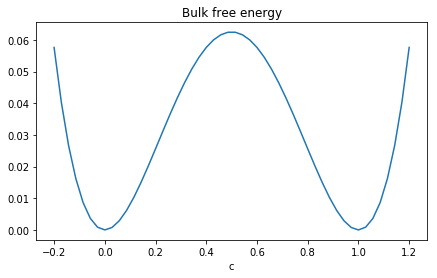

In [4]:
plt.figure(figsize=(7,4))
plt.sympy_function(bulk_free_energy_density.subs(A, 1), (-0.2, 1.2))
plt.xlabel("c")
plt.title("Bulk free energy");

To minimize the total free energy we use the Cahn Hilliard equation

$$\partial_t c = \nabla \cdot \left( M \nabla \frac{\delta F}{\delta c} \right)$$

where the functional derivative $\frac{\delta F}{\delta c}$ in this case is the chemical potential $\mu$.
A functional derivative is computed as 
$\frac{\delta F}{\delta c} = \frac{\partial F}{\partial c} - \nabla \cdot \frac{\partial F}{\partial \nabla c}$. 
That means we treat $\nabla c$ like a normal variable when calculating derivatives.

We don't have to worry about that in detail, since pystencils offers a function to do just that:

In [5]:
ps.fd.functional_derivative(free_energy_density, c)

In this case we could quite simply do this derivative by hand but for more complex phase field models this step is quite tedious.

If we discretize this term using finite differences, we have a computation rule how to compute the chemical potential $\mu$ from the free energy.

In [6]:
discretize = ps.fd.Discretization2ndOrder(dx=1, dt=0.01)

μ_update_eq = ps.fd.functional_derivative(free_energy_density, c)
μ_update_eq = ps.fd.expand_diff_linear(μ_update_eq, constants=[κ])  # pull constan κ in front of the derivatives
μ_update_eq_discretized = discretize(μ_update_eq)
μ_update_eq_discretized

pystencils computed the finite difference approximation for us. This was only possible since all symbols occuring inside derivatives are pystencils field variables, so that neighboring values can be accessed.
Next we bake this formula into a kernel that writes the chemical potential to a field. Therefor we first insert the $\kappa$ and $A$ parameters, build an assignment out of it and compile the kernel

In [7]:
μ_kernel = ps.create_kernel([ps.Assignment(μ_field.center, 
                                           μ_update_eq_discretized.subs(A, 1).subs(κ, 0.5))]
                           ).compile()

Next, we formulate the Cahn-Hilliard equation itself, which is just a diffusion equation:

In [8]:
M = sp.Symbol("M")
cahn_hilliard = ps.fd.transient(c) - ps.fd.diffusion(μ, M)
cahn_hilliard

-Diffusion(μ_C, M) + Transient(c_C)

It can be given right away to the `discretize` function, that by default uses a simple explicit Euler scheme for temporal, and second order finite differences for spatial discretization. 
It returns the update rule for the concentration field.

In [9]:
c_update = discretize(cahn_hilliard)
c_update

Again, we build a kernel from this update rule:

In [10]:
c_kernel = ps.create_kernel([ps.Assignment(c_field.center, 
                                           c_update.subs(M, 1))]
                           ).compile()

Before we run the simulation, the domain has to be initialized. To access a numpy array inside a data handling we have to iterate over the data handling. This somewhat complicated way is necessary to be able to switch to distributed memory parallel simulations without having to alter the code. Basically this loops says "iterate over the portion of the domain that belongs to my process", which in our serial case here is just the full domain. 

As suggested in the book, we initialize everything with $c=0.4$ and add some random noise on top of it.

In [11]:
def init(value=0.4, noise=0.02):
    for b in dh.iterate():
        b['c'].fill(value)
        np.add(b['c'], noise*np.random.rand(*b['c'].shape), out=b['c'])

The time loop of the simulation is now rather straightforward. We call the kernels to update the chemical potential and the concentration in alternating fashion. In between we have to do synchronization steps for the fields that take care of the periodic boundary condition, and in the parallel case of the communciation between processes. 

In [12]:
def timeloop(steps=100):
    c_sync = dh.synchronization_function(['c'])
    μ_sync = dh.synchronization_function(['mu'])
    for t in range(steps):
        c_sync()
        dh.run_kernel(μ_kernel)
        μ_sync()
        dh.run_kernel(c_kernel)
    return dh.gather_array('c')
init()

Now we can run the simulation and see how the phases separate

In [13]:
if 'is_test_run' in globals():
    timeloop(10)
    result = None
else:
    ps_notebook.set_display_mode('video')
    ani = ps.plot2d.scalar_field_animation(timeloop, rescale=True, frames=600)
    result = ps_notebook.display_animation(ani)
result

Now there are a lot of places one could alter and play with this model. Here a few ideas:

- try different initial conditions and/or parameters $\kappa, A$
- the model can be generalized to 3D, by altering the DataHandling and the plot commands
- modify the free energy formulation, make one minima lower than the other, maybe even add another phase